In [24]:
%matplotlib inline


# 2.5D DC Resistivity and IP Least-Squares Inversion

Here we invert a line of DC resistivity and induced polarization data to
recover electrical conductivity and chargeability models, respectively.
We formulate the corresponding inverse problems as least-squares
optimization problems. For this tutorial, we focus on the following:

    - Defining the survey
    - Generating a mesh based on survey geometry
    - Including surface topography
    - Defining the inverse problem (data misfit, regularization, directives)
    - Applying sensitivity weighting
    - Plotting the recovered model and data misfit


## Import modules




In [25]:
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz

from SimPEG.utils import surface2ind_topo
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static import induced_polarization as ip
from SimPEG.electromagnetics.static.utils.static_utils import plot_pseudoSection

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

# sphinx_gallery_thumbnail_number = 6

## Get files

stored in .\data


In [26]:


# path to the directory containing our data
data_path = Path('data')

# files to work with
topo_filename = Path(data_path / "rv_dipole_dipole_topo.txt")
dc_data_filename = Path(data_path / "rv_dipole_dipole_dc.txt")
ip_data_filename = Path(data_path / "rv_dipole_dipole_ip.txt")

## Load Data, Define Survey and Plot

Here we load the observed data, define the DC and IP survey geometry and
plot the data values using pseudo-sections.




In [27]:
# Load data
topo_xz = np.loadtxt(topo_filename)
dobs_dc = np.loadtxt(dc_data_filename)
dobs_ip = np.loadtxt(ip_data_filename)

C:\Users\cwgeo\miniconda3\envs\simpeg\lib\site-packages\SimPEG\electromagnetics\static\utils\static_utils.py:461: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ph = ax.pcolormesh(
C:\Users\cwgeo\miniconda3\envs\simpeg\lib\site-packages\SimPEG\electromagnetics\static\utils\static_utils.py:508: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(-ticks / spacing)


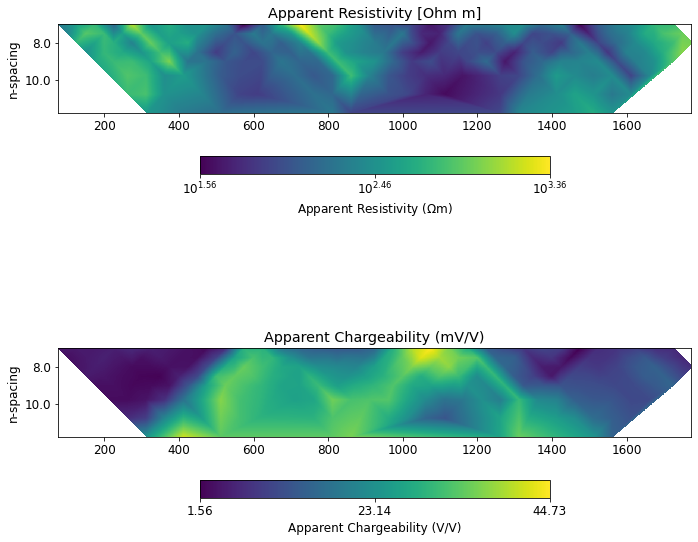

In [29]:
# Extract source and receiver electrode locations and the observed data
#  we are assuming the dc and ip tx-rx pairs are the same. In this case they are.
A_electrodes = np.c_[dobs_dc[:, 0], np.zeros(dobs_dc.shape[0])]
B_electrodes = np.c_[dobs_dc[:, 1], np.zeros(dobs_dc.shape[0])]
M_electrodes = np.c_[dobs_dc[:, 2], np.zeros(dobs_dc.shape[0])]
N_electrodes = np.c_[dobs_dc[:, 3], np.zeros(dobs_dc.shape[0])]
dobs_dc = dobs_dc[:, -1]
dobs_ip = dobs_ip[:, -1]

# Define survey
unique_tx, k = np.unique(np.c_[A_electrodes, B_electrodes], axis=0, return_index=True)
n_sources = len(k)
k = np.r_[k, len(A_electrodes) + 1]

source_list = []
for ii in range(0, n_sources):

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = M_electrodes[k[ii] : k[ii + 1], :]
    N_locations = N_electrodes[k[ii] : k[ii + 1], :]
    receiver_list = [dc.receivers.Dipole(M_locations, N_locations, data_type="volt")]

    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = A_electrodes[k[ii], :]
    B_location = B_electrodes[k[ii], :]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
dc_survey = dc.survey.Survey_ky(source_list)
ip_survey = ip.from_dc_to_ip_survey(dc_survey, dim="2.5D")

# Define the a data object. Uncertainties are added later
dc_data = data.Data(dc_survey, dobs=dobs_dc)
ip_data = data.Data(ip_survey, dobs=dobs_ip)

# Plot apparent resistivity using pseudo-section
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(11, 9))

ax1 = fig.add_axes([0.05, 0.55, 0.8, 0.45])
plot_pseudoSection(
    dc_data,
    ax=ax1,
    survey_type="pole-dipole",
    data_type="appResistivity",
    space_type="half-space",
    scale="log",
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Apparent Resistivity [Ohm m]")

ax2 = fig.add_axes([0.05, 0.05, 0.8, 0.45])
plot_pseudoSection(
    ip_data,
    ax=ax2,
    survey_type="pole-dipole",
    data_type="appChargeability",
    space_type="half-space",
    scale="linear",
    pcolorOpts={"cmap": "plasma"},
)
ax2.set_title("Apparent Chargeability (mV/V)")

plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define standard deviation on our data.
This represents our estimate of the noise in our data. For DC data, a relative
error is applied to each datum. For this tutorial, the relative error on each
datum will be 5%. For IP data, a percent of the DC data is used for the
standard deviation. For this tutorial, the standard deviation on IP data are
1% of the corresponding DC data value.




In [30]:
# Compute standard deviations
std_dc = 0.05 * np.abs(dobs_dc)
std_ip = 0.01 * np.abs(dobs_dc)

# Add standard deviations to data object
dc_data.standard_deviation = std_dc
ip_data.standard_deviation = std_ip

## Create OcTree Mesh

Here, we create the OcTree mesh that will be used to predict both DC
resistivity and IP data.




In [31]:
dh = 10.0  # base cell width
dom_width_x = 2400.0  # domain width x
dom_width_z = 1200.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Mesh refinement based on topography
mesh = refine_tree_xyz(
    mesh, topo_xyz[:, [0, 2]], octree_levels=[1], method="surface", finalize=False
)

# Mesh refinement near transmitters and receivers
electrode_locations = np.r_[
    dc_survey.locations_a,
    dc_survey.locations_b,
    dc_survey.locations_m,
    dc_survey.locations_n,
]

unique_locations = np.unique(electrode_locations, axis=0)

mesh = refine_tree_xyz(
    mesh, unique_locations, octree_levels=[2, 4], method="radial", finalize=False
)

# Refine core mesh region
xp, zp = np.meshgrid([-800.0, 800.0], [-800.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(zp)]
mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2, 2], method="box", finalize=False)

mesh.finalize()

IndexError: index 2 is out of bounds for axis 1 with size 2

## Project Surveys to Discretized Topography

It is important that electrodes are not model as being in the air. Even if the
electrodes are properly located along surface topography, they may lie above
the discretized topography. This step is carried out to ensure all electrodes
like on the discretized surface.




In [ ]:
# Find cells that lie below surface topography
ind_active = surface2ind_topo(mesh, topo_xyz[:, [0, 2]])

# Shift electrodes to the surface of discretized topography
dc_survey.drape_electrodes_on_topography(mesh, ind_active, option="top")
ip_survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

## Starting/Reference Model and Mapping on OcTree Mesh

Here, we would create starting and/or reference models for the DC inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is the natural log of 0.01 S/m.




In [ ]:
# Define conductivity model in S/m (or resistivity model in Ohm m)
air_conductivity = np.log(1e-8)
background_conductivity = np.log(1e-2)

active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(ind_active.sum())

conductivity_map = active_map * maps.ExpMap()

# Define model
starting_conductivity_model = background_conductivity * np.ones(nC)

## Define the Physics of the DC Simulation

Here, we define the physics of the DC resistivity problem.




In [ ]:
# Define the problem. Define the cells below topography and the mapping
dc_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=dc_survey, sigmaMap=conductivity_map, Solver=Solver
)

## Define DC Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem





In [ ]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dc_data_misfit = data_misfit.L2DataMisfit(data=dc_data, simulation=dc_simulation)

# Define the regularization (model objective function)
dc_regularization = regularization.Simple(
    mesh,
    indActive=ind_active,
    mref=starting_conductivity_model,
    alpha_s=0.01,
    alpha_x=1,
    alpha_y=1,
)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
dc_optimization = optimization.ProjectedGNCG(
    maxIter=5, lower=-10.0, upper=2.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
dc_inverse_problem = inverse_problem.BaseInvProblem(
    dc_data_misfit, dc_regularization, dc_optimization
)

## Define DC Inversion Directives

Here we define any directives that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [ ]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=2)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

## Running the DC Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [ ]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(
    dc_inverse_problem, directiveList=directives_list
)

# Run inversion
recovered_conductivity_model = dc_inversion.run(starting_conductivity_model)

## Plotting True and Recovered Conductivity Model




In [ ]:
# Load true conductivity model
true_conductivity_model = np.loadtxt(str(true_conductivity_filename))
true_conductivity_model_log10 = np.log10(true_conductivity_model[ind_active])

# Plot True Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.ActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.72, 0.8])
mesh.plotImage(
    plotting_map * true_conductivity_model_log10,
    ax=ax1,
    grid=False,
    clim=(np.min(true_conductivity_model_log10), np.max(true_conductivity_model_log10)),
    range_x=[-700, 700],
    range_y=[-700, 0],
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("True Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.83, 0.12, 0.05, 0.8])
norm = mpl.colors.Normalize(
    vmin=np.min(true_conductivity_model_log10),
    vmax=np.max(true_conductivity_model_log10),
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis, format="10^%.1f"
)

cbar.set_label("$S/m$", rotation=270, labelpad=15, size=12)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))

# Make conductivities in log10
recovered_conductivity_model_log10 = np.log10(np.exp(recovered_conductivity_model))

ax1 = fig.add_axes([0.1, 0.12, 0.72, 0.8])
mesh.plotImage(
    plotting_map * recovered_conductivity_model_log10,
    normal="Y",
    ax=ax1,
    grid=False,
    clim=(np.min(true_conductivity_model_log10), np.max(true_conductivity_model_log10)),
    range_x=[-700, 700],
    range_y=[-700, 0],
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Recovered Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.83, 0.12, 0.05, 0.8])
norm = mpl.colors.Normalize(
    vmin=np.min(true_conductivity_model_log10),
    vmax=np.max(true_conductivity_model_log10),
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis, format="10^%.1f"
)
cbar.set_label("$S/m$", rotation=270, labelpad=15, size=12)

plt.show()

## Plotting Predicted DC Data and Misfit




In [ ]:
# Predicted data from recovered model
dpred_dc = dc_inverse_problem.dpred
dc_data_predicted = data.Data(dc_survey, dobs=dpred_dc)

data_array = [dc_data, dc_data_predicted, dc_data]
dobs_array = [None, None, (dobs_dc - dpred_dc) / std_dc]

fig = plt.figure(figsize=(17, 5.5))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_type = ["appConductivity", "appConductivity", "misfitMap"]
plot_units = ["S/m", "S/m", ""]
scale = ["log", "log", "linear"]

ax1 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):

    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.05, 0.25, 0.9])
    cplot[ii] = plot_pseudoSection(
        data_array[ii],
        dobs=dobs_array[ii],
        ax=ax1[ii],
        survey_type="dipole-dipole",
        data_type=plot_type[ii],
        scale=scale[ii],
        space_type="half-space",
        pcolorOpts={"cmap": "viridis"},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

## Starting/Reference Model for IP Inversion

Here, we would create starting and/or reference models for the IP inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is the 1e-6 V/V.





In [ ]:
# Define conductivity model in S/m (or resistivity model in Ohm m)
air_chargeability = 0.0
background_chargeability = 1e-6

active_map = maps.InjectActiveCells(mesh, ind_active, air_chargeability)
nC = int(ind_active.sum())

chargeability_map = active_map

# Define model
starting_chargeability_model = background_chargeability * np.ones(nC)

## Define the Physics of the IP Simulation

Here, we define the physics of the IP problem. For the chargeability, we
require a mapping from the model space to the entire mesh. For the background
conductivity/resistivity, we require the conductivity/resistivity on the
entire mesh.




In [ ]:
ip_simulation = ip.simulation_2d.Simulation2DNodal(
    mesh,
    survey=ip_survey,
    etaMap=chargeability_map,
    sigma=conductivity_map * recovered_conductivity_model,
    Solver=Solver,
)

## Define IP Inverse Problem

Here we define the inverse problem in the same manner as the DC inverse problem.




In [ ]:
# Define the data misfit (Here we use weighted L2-norm)
ip_data_misfit = data_misfit.L2DataMisfit(data=ip_data, simulation=ip_simulation)

# Define the regularization (model objective function)
ip_regularization = regularization.Simple(
    mesh,
    indActive=ind_active,
    mapping=maps.IdentityMap(nP=nC),
    alpha_s=1,
    alpha_x=1,
    alpha_y=1,
)

# Define how the optimization problem is solved.
ip_optimization = optimization.ProjectedGNCG(
    maxIter=10, lower=0.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
ip_inverse_problem = inverse_problem.BaseInvProblem(
    ip_data_misfit, ip_regularization, ip_optimization
)

## Define IP Inversion Directives

Here we define the directives in the same manner as the DC inverse problem.




In [ ]:
update_sensitivity_weighting = directives.UpdateSensitivityWeights(threshold=1e-3)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e2)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

## Define IP Inversion Directives

Here we define the directives in the same manner as the DC inverse problem.




In [ ]:
# Here we combine the inverse problem and the set of directives
ip_inversion = inversion.BaseInversion(
    ip_inverse_problem, directiveList=directives_list
)

# Run inversion
recovered_chargeability_model = ip_inversion.run(starting_chargeability_model)

## Plotting True Model and Recovered Chargeability Model




In [ ]:
true_chargeability_model = np.loadtxt(str(true_chargeability_filename))
true_chargeability_model = true_chargeability_model[ind_active]


# Plot True Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.ActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.72, 0.8])
mesh.plotImage(
    plotting_map * true_chargeability_model,
    ax=ax1,
    grid=False,
    clim=(np.min(true_chargeability_model), np.max(true_chargeability_model)),
    range_x=[-700, 700],
    range_y=[-700, 0],
    pcolorOpts={"cmap": "plasma"},
)
ax1.set_title("True Chargeability Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.83, 0.12, 0.03, 0.8])
norm = mpl.colors.Normalize(
    vmin=np.min(true_chargeability_model), vmax=np.max(true_chargeability_model)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("Intrinsic Chargeability (V/V)", rotation=270, labelpad=15, size=12)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.1, 0.12, 0.72, 0.8])
mesh.plotImage(
    plotting_map * recovered_chargeability_model,
    normal="Y",
    ax=ax1,
    grid=False,
    clim=(np.min(recovered_chargeability_model), np.max(recovered_chargeability_model)),
    range_x=[-700, 700],
    range_y=[-700, 0],
    pcolorOpts={"cmap": "plasma"},
)
ax1.set_title("Recovered Chargeability Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.83, 0.12, 0.03, 0.8])
norm = mpl.colors.Normalize(
    vmin=np.min(recovered_chargeability_model),
    vmax=np.max(recovered_chargeability_model),
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("Intrinsic Chargeability (V/V)", rotation=270, labelpad=15, size=12)

plt.show()

## Plotting Predicted Data and Misfit




In [ ]:
dpred_ip = ip_inverse_problem.dpred
ip_data_predicted = data.Data(ip_survey, dobs=dpred_ip)

# Convert from voltage measurements to apparent chargeability by normalizing by
# the DC voltage
dobs_array = np.c_[dobs_ip / dobs_dc, dpred_ip / dobs_dc, (dobs_ip - dpred_ip) / std_ip]

fig = plt.figure(figsize=(17, 5.5))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_type = ["appChargeability", "appChargeability", "volt"]
scale = ["linear", "linear", "linear"]

ax1 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):

    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.23, 0.85])
    cplot[ii] = plot_pseudoSection(
        ip_data,
        dobs=dobs_array[:, ii],
        ax=ax1[ii],
        survey_type="dipole-dipole",
        data_type=plot_type[ii],
        space_type="half-space",
        pcolorOpts={"cmap": "plasma"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("z (m)")

plt.show()